## Lecture 14: Matrix-Vector Representation of Image Operations

Goal: to describe common image operations (transforms, filtering) as matrix-vector operations. One important skill in computational imaging applications is to be able to go back and forth between the matrix-vector formulations used in theory, and the image operations often implemented and visualized in practice. 




In [10]:
## MP 574 Lecture 14: Matrix-vector operations
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd
import skimage.transform as transform
import skimage.data as data
import scipy.sparse as sparse

font = {'weight' : 'normal',
        'size'   : 12}
np.set_printoptions(precision=2)

## DFT

If we view the DFT operation as a matrix-vector operation, we can implement it by simply reshaping our vector into an image with the right dimensions, applying the (2D) DFT using an FFT algorithm, and reshaping the output back into a vector.

Now, the question is how to implement the transpose of this operation (Hermitian transpose in the case of DFT since it is a complex-valued operation). However, for the case of the DFT, we know that this is an orthogonal operation where its transpose is its inverse (up to a scaling factor given by the size of the array). In other words, the transpose of the DFT matrix is the iDFT matrix (up to a scaling factor since the DFT matrix is not normalized).

In [2]:
# Calculate y = F x
x2 = data.shepp_logan_phantom()
x2 = transform.rescale(x2, scale=0.4, mode='reflect', multichannel=False)
N1,N2 = x2.shape
x = np.reshape(x2,(N1*N2,1)) # This is the vectorized image (column vector)
y2 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x2)))
y = np.reshape(y2,(N1*N2,1)) # This is the vectorized Fourier data (column vector)

# Now z = F^T y
z2 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(y2)))*N1*N2
z = np.reshape(z2,(N1*N2,1)) # This is the vectorized image data (column vector)

## Subsampling

In our reconstructions, we often want to fit data acquired at a subset of the Fourier locations provided by the DFT. For instance, we may skip some lines or some locations within an $N \times N$ Cartesian array. In this case, the forward matrix can be viewed as $\mathbf{A} = \mathbf{U} \mathbf{F}$ where $\mathbf{F}$ performs a 2D DFT, and $\mathbf{U}$ is a diagonal matrix with all the rows corresponding to unsampled Fourier space entries removed. 

Implementing the effect of $\mathbf{U}$  on a vectorized array is easy. Suppose we have a $N \times N$ array and we have a binary 'mask' (call it 'M') that specifies which entries of the array we are actually sampling. Then we can simply select the corresponding entries specified by our binary mask M (ie: where M=True).

The transpose of this operation is the zero-padding operation, where we take the input (of length the number of sampled entries), and add zeroes at the non-sampled entries.

In [3]:
# Subsampling operation described by an image-based mask M
M = np.zeros((N1,N2),dtype=bool)
M[60:100,60:100] = True
y_sub = y[np.reshape(M,(N1*N2,1))]
#plt.figure(figsize=(4,4))
#plt.imshow(np.abs(M*y2))

# Transpose of subsampling operation: zero-padding
z = np.zeros((N1*N2,1),dtype='cfloat') 
z[np.reshape(M,(N1*N2,1))] = y_sub
z2 = np.reshape(z,(N1,N2))

## Radon transform

Given an image and a set of projection angles, we can perform a radon transform (ie: projections along a set of angles), as implemented in Python. 

Importantly, the transpose of the radon transform is the (unfiltered) backprojection (including some additional scaling, as shown below).

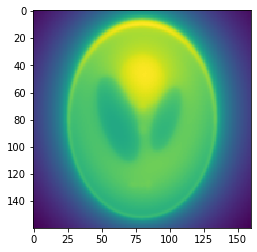

In [5]:
# Radon transform
theta = np.linspace(0., 180., 180, endpoint=False)
y2 = transform.radon(x2, theta=theta, circle=False)
M1,M2 = y2.shape
y = np.reshape(y2,(M1*M2,1))

# Transpose of Radon transform
z2 = 2*M2/np.pi*transform.iradon(y2, theta=theta, circle=False,filter=None)


plt.figure(figsize=(4,4))
plt.imshow(z2)

## Filtering 

Oftentimes we want to implement a high pass filter as part of a regularization term (ie: $\| \mathbf{Dx} \|_p$). Here are two alternative implementations of the filter and its transpose: i) based on image shifts and additions/subtractions, ii) based on creating a finite-difference taking matrix in 1D, and extending to 2D using the kronecker product (kron command). In this implementation, we keep the memory requirements in check by making our huge matrix sparse (a type of array allocation in Python, efficient for storing and operating with sparse arrays). 

In [37]:
# Implementation 1
y2a = 4*x2 - np.roll(x2,1,axis=0) - np.roll(x2,-1,axis=0) - np.roll(x2,1,axis=1) - np.roll(x2,-1,axis=1)
z2a = 4*y2 - np.roll(y2,1,axis=0) - np.roll(y2,-1,axis=0) - np.roll(y2,1,axis=1) - np.roll(y2,-1,axis=1)

# Implementation 2
N1,N2 = x2.shape
I = np.eye(N1)
D = 2*I - np.roll(I,-1,axis=1) - np.roll(I,1,axis=1)
D = sparse.csr_matrix(D) 
I = sparse.eye(N1)
D2 = sparse.kron(D,I) + sparse.kron(I,D)
y = D2.dot(np.reshape(x2,(N1*N2,1)))
y2b = np.reshape(y,(N1,N2))
z = (D2.T).dot(y)
z2b = np.reshape(z,(N1,N2))

#plt.figure(figsize=(4,4))
#plt.imshow(y2a);

## Multiplication with a diagonal weighting matrix

Multiplication with a diagonal matrix $\mathbf{W}$ (ie: a square matrix where the only nonzero entries are along the diagonal) is needed frequently in image reconstruction and other algorithms. This operation is also particularly easy, since it reduces to a pointwise multiplication between two arrays (or vectors, or images, depending on how we have formatted them). If we want to calculate $\mathbf{y} = \mathbf{W} \mathbf{x}$, where  $\mathbf{W}$ is a diagonal matrix, then we can simply calculate each entry of $\mathbf{y}$ as $y_n = W_{nn} x_n$.

In [40]:
# Set some random weights (diagonal of W)
w = np.random.rand(N1,N2) 

# Multiply with diagonal weighting matrix W (pointwise multiplication with w)
# Note python syntax is different from matlab (no ".*" in python)
y2 = w*x2

# Transpose is the same operation (conjugate w if complex)
z2 = w*y2